<a href="https://colab.research.google.com/github/leo0622nycu/Essay/blob/main/ARIMA%2BMLP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
drive.mount('/content/drive')

Monthly_Revenue = pd.read_csv('/content/drive/MyDrive/CSV/Historical_Monthly_Revenue_November_2.csv')
ARIMA_TRAIN = pd.read_csv('/content/drive/MyDrive/CSV/ARIMA_TRAIN.csv')
ARIMA_TEST = pd.read_csv('/content/drive/MyDrive/CSV/ARIMA_TEST.csv')
residuals_all = pd.read_csv('/content/drive/MyDrive/CSV/residuals_all.csv')

Mounted at /content/drive


In [3]:
print(ARIMA_TRAIN.head())
print(ARIMA_TEST.head())
print(residuals_all.head())

         time  revenue  predicted_mean
0  2014-01-01  51430.0    30185.751353
1  2014-02-01  46829.0    37736.236749
2  2014-03-01  49956.0    64449.814235
3  2014-04-01  61887.0    48770.798303
4  2014-05-01  60789.0    46333.241718
         time   revenue  predicted_mean
0  2022-09-01  208248.0   197532.898379
1  2022-10-01  210266.0   210548.390823
2  2022-11-01  222706.0   218088.081253
3  2022-12-01  192560.0   217654.802244
4  2023-01-01  200051.0   204526.895095
   Unnamed: 0       revenue
0  2014-01-01  21244.248647
1  2014-02-01   9092.763251
2  2014-03-01 -14493.814235
3  2014-04-01  13116.201697
4  2014-05-01  14455.758282


In [4]:
ARIMA_OUTPUT = pd.concat([ARIMA_TRAIN, ARIMA_TEST], axis=0)
ARIMA_OUTPUT['diff_1'] = ARIMA_OUTPUT['revenue'].diff()
ARIMA_OUTPUT['residuals'] = residuals_all['revenue']

# 更改 diff_1 第一個值
ARIMA_OUTPUT.loc[0, 'diff_1'] = 1749

# 將 'time‘ 設為索引，並確認其為 DatetimeIndex
ARIMA_OUTPUT.set_index('time', inplace=True)

# 將索引轉為 Datetime 格式（如果尚未是 datetime）
ARIMA_OUTPUT.index = pd.to_datetime(ARIMA_OUTPUT.index)

# 檢查結果
print(ARIMA_OUTPUT.head())


            revenue  predicted_mean   diff_1     residuals
time                                                      
2014-01-01  51430.0    30185.751353   1749.0  21244.248647
2014-02-01  46829.0    37736.236749  -4601.0   9092.763251
2014-03-01  49956.0    64449.814235   3127.0 -14493.814235
2014-04-01  61887.0    48770.798303  11931.0  13116.201697
2014-05-01  60789.0    46333.241718  -1098.0  14455.758282


In [5]:
ARIMA_OUTPUT.to_csv('ARIMA_OUTPUT.csv', header=True)

from google.colab import files
files.download('ARIMA_OUTPUT.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# Initialize features and targets
X_grouped = []
Y_grouped = []

# Construct features and targets
for i in range(3, len(ARIMA_OUTPUT)):
    # Lagged diff_1 and residuals (2 lags)
    x_diff_1 = ARIMA_OUTPUT['diff_1'].iloc[i-3:i].values.tolist()
    x_residuals = ARIMA_OUTPUT['residuals'].iloc[i-1:i].values.tolist()

    # Next predicted_mean value (from index i)
    x_predicted_mean = [ARIMA_OUTPUT['predicted_mean'].iloc[i]]

    # Organize into grouped structure
    x_grouped = {
        'diff_1': x_diff_1,
        'residuals': x_residuals,
        'predicted_mean': x_predicted_mean,
    }
    X_grouped.append(x_grouped)

    # Next revenue value (from index i)
    y_value = ARIMA_OUTPUT['revenue'].iloc[i]
    Y_grouped.append(y_value)

# Confirm the result
print( X_grouped)
print( Y_grouped)



[{'diff_1': [1749.0, -4601.0, 3127.0], 'residuals': [-14493.814235076592], 'predicted_mean': [48770.79830284205]}, {'diff_1': [-4601.0, 3127.0, 11931.0], 'residuals': [13116.20169715795], 'predicted_mean': [46333.24171781883]}, {'diff_1': [3127.0, 11931.0, -1098.0], 'residuals': [14455.758282181168], 'predicted_mean': [66884.56265770072]}, {'diff_1': [11931.0, -1098.0, -445.0], 'residuals': [-6540.562657700721], 'predicted_mean': [67303.87900326829]}, {'diff_1': [-1098.0, -445.0, 4581.0], 'residuals': [-2378.879003268288], 'predicted_mean': [55925.28980677408]}, {'diff_1': [-445.0, 4581.0, 4354.0], 'residuals': [13353.710193225916], 'predicted_mean': [66801.66008777673]}, {'diff_1': [4581.0, 4354.0, 5567.0], 'residuals': [8044.339912223266], 'predicted_mean': [78691.45722754268]}, {'diff_1': [4354.0, 5567.0, 5890.0], 'residuals': [2044.542772457324], 'predicted_mean': [76907.13639411461]}, {'diff_1': [5567.0, 5890.0, -8461.0], 'residuals': [-4632.136394114612], 'predicted_mean': [73869

In [7]:
# 將分群特徵展平成單一數組
X_flattened = []
for x in X_grouped:
    flattened = x['diff_1'] + x['predicted_mean'] +  x['residuals']  # 展平結構
    X_flattened.append(flattened)


# 轉換為 NumPy 陣列
X_flattened = [x for x in X_flattened if all(val is not None for val in x)]
Y_grouped = [y for y in Y_grouped if y is not None]

# 確認形狀
print(X_flattened)
print(Y_grouped)


[[1749.0, -4601.0, 3127.0, 48770.79830284205, -14493.814235076592], [-4601.0, 3127.0, 11931.0, 46333.24171781883, 13116.20169715795], [3127.0, 11931.0, -1098.0, 66884.56265770072, 14455.758282181168], [11931.0, -1098.0, -445.0, 67303.87900326829, -6540.562657700721], [-1098.0, -445.0, 4581.0, 55925.28980677408, -2378.879003268288], [-445.0, 4581.0, 4354.0, 66801.66008777673, 13353.710193225916], [4581.0, 4354.0, 5567.0, 78691.45722754268, 8044.339912223266], [4354.0, 5567.0, 5890.0, 76907.13639411461, 2044.542772457324], [5567.0, 5890.0, -8461.0, 73869.763496147, -4632.136394114612], [5890.0, -8461.0, -2765.0, 73931.07812325738, -4359.763496147003], [-8461.0, -2765.0, 17610.0, 77583.79914647785, 13188.92187674262], [-2765.0, 17610.0, -24475.0, 70612.11761715668, -14938.799146477846], [17610.0, -24475.0, 9624.0, 75514.98761094878, 1656.8823828433233], [-24475.0, 9624.0, 3061.0, 65487.03577740581, -184.98761094878137], [9624.0, 3061.0, -5175.0, 74472.95608177179, 4667.964222594193], [306

In [8]:
train_X = X_flattened[:101]
train_Y = Y_grouped[:101]

test_X =  X_flattened[101:]
test_Y = Y_grouped[101:]

print(train_X)
print(train_Y)
print(test_X)
print(test_Y)

[[1749.0, -4601.0, 3127.0, 48770.79830284205, -14493.814235076592], [-4601.0, 3127.0, 11931.0, 46333.24171781883, 13116.20169715795], [3127.0, 11931.0, -1098.0, 66884.56265770072, 14455.758282181168], [11931.0, -1098.0, -445.0, 67303.87900326829, -6540.562657700721], [-1098.0, -445.0, 4581.0, 55925.28980677408, -2378.879003268288], [-445.0, 4581.0, 4354.0, 66801.66008777673, 13353.710193225916], [4581.0, 4354.0, 5567.0, 78691.45722754268, 8044.339912223266], [4354.0, 5567.0, 5890.0, 76907.13639411461, 2044.542772457324], [5567.0, 5890.0, -8461.0, 73869.763496147, -4632.136394114612], [5890.0, -8461.0, -2765.0, 73931.07812325738, -4359.763496147003], [-8461.0, -2765.0, 17610.0, 77583.79914647785, 13188.92187674262], [-2765.0, 17610.0, -24475.0, 70612.11761715668, -14938.799146477846], [17610.0, -24475.0, 9624.0, 75514.98761094878, 1656.8823828433233], [-24475.0, 9624.0, 3061.0, 65487.03577740581, -184.98761094878137], [9624.0, 3061.0, -5175.0, 74472.95608177179, 4667.964222594193], [306

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


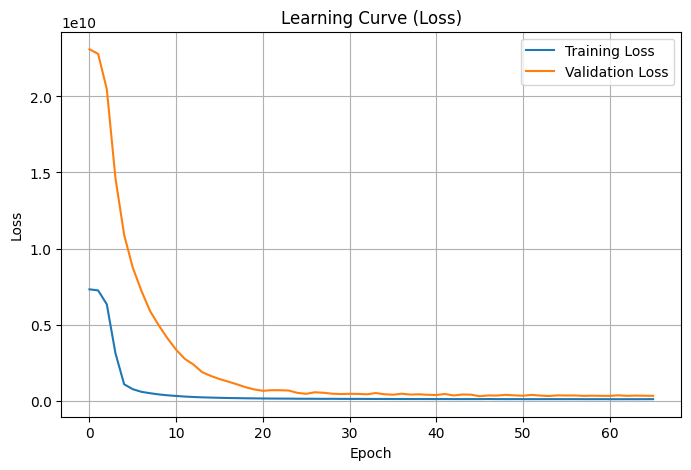

In [97]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 假設已經有 train_X, train_Y, test_X, test_Y

# 1. 把特徵標準化
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# 2. 構建 MLP 模型
model = Sequential()
model.add(Dense(128, activation='relu',input_dim=train_X_scaled.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # 單一輸出 (revenue)
model.compile(optimizer='adam', loss='mse', metrics=['mape'])

# 3. 定義回調函數
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# 4. 訓練模型
train_Y = np.array(train_Y)
history = model.fit(
    train_X_scaled, train_Y,
    validation_split=0.2,  # 使用 20% 的訓練數據進行驗證
    epochs=2000,
    batch_size=1,
    callbacks=[early_stopping],
    verbose=0
)

import matplotlib.pyplot as plt

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


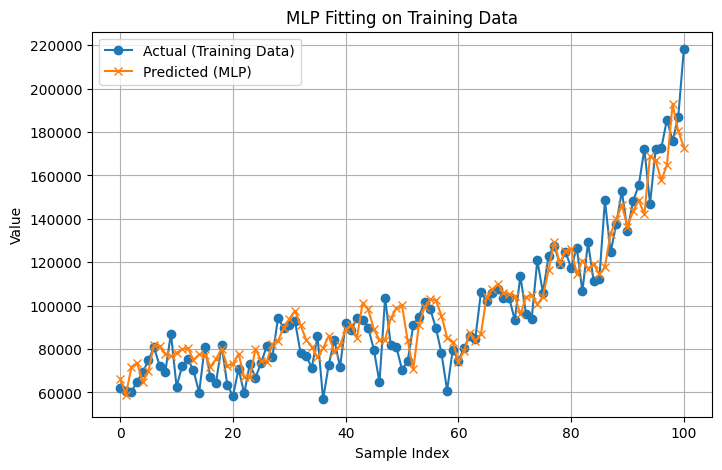

In [98]:
import matplotlib.pyplot as plt

# 假設 X, y 是你的訓練集 (由 split_sequence() 產生)
# 訓練完成後：
y_pred_train = model.predict(train_X_scaled)  # 模型在訓練集上的預測

plt.figure(figsize=(8, 5))


plt.plot(range(len(train_Y)), train_Y, marker='o', label='Actual (Training Data)')


y_pred_train_1d = y_pred_train.flatten()
plt.plot(range(len(y_pred_train_1d)), y_pred_train_1d, marker='x', label='Predicted (MLP)')

plt.title('MLP Fitting on Training Data')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


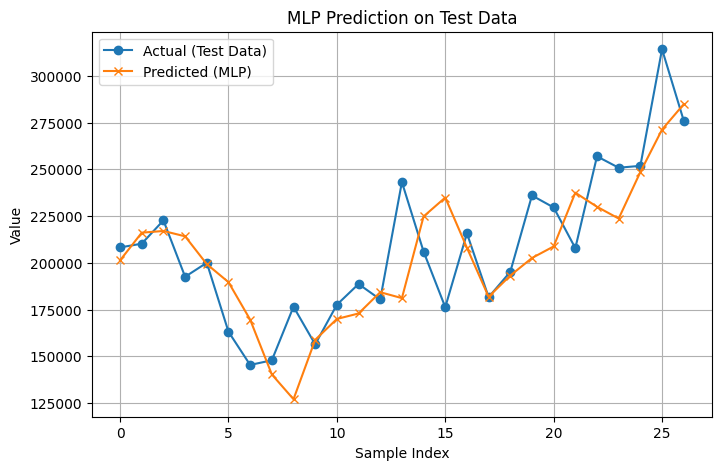

In [99]:
y_pred_test = model.predict(test_X_scaled)

plt.figure(figsize=(8, 5))


plt.plot(range(len(test_Y)), test_Y, marker='o', label='Actual (Test Data)')


y_pred_test_1d = y_pred_test.flatten()
plt.plot(range(len(y_pred_test_1d)), y_pred_test_1d, marker='x', label='Predicted (MLP)')

plt.title('MLP Prediction on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np



# 1. 計算 RMSE
rmse = np.sqrt(mean_squared_error(test_Y, y_pred_test_1d))

# 2. 計算 MAE
mae = mean_absolute_error(test_Y, y_pred_test_1d)

# 3. 計算 MAPE
mape = np.mean(np.abs((test_Y - y_pred_test_1d) / test_Y)) * 100

# 4. 輸出結果
print(f"RMSE : {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")

RMSE : 25990.48
MAE : 19287.68
MAPE : 9.34%
